In [1]:
## for data
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition## for explainer
from lime import lime_tabular

In [2]:
# Don't have any existing modeling code on hand to start from, so grabbing the basic components from this tutorial
# https://towardsdatascience.com/machine-learning-with-python-regression-complete-tutorial-47268e546cea

In [3]:
analysis6M = pd.read_csv('GBC train 06M.csv')

In [4]:
# Get down to just the columns we need - this has extra Time Offset columns 
analysis6M = analysis6M.loc[:, ['Month', 'max_ratio', 'CLI', 'BCI', 'CCI', 'Employment Rate', 'CPI',
       'LTI Rate', 'PPI', 'STI Rate', 'Unemployment Rate']]

analysis6M.set_index('Month', inplace = True)

analysis6M.head()

,max_ratio,CLI,BCI,CCI,Employment Rate,CPI,LTI Rate,PPI,STI Rate,Unemployment Rate
Month,,,,,,,,,,
2016-01-01,4.573529,0.02460,-0.31084,0.7940,-1.170,0.6907,2.32,1.58990,0.19,5.2
2016-02-01,5.147059,-0.16384,-0.51555,0.5875,-0.819,0.5481,2.17,0.78150,0.26,5.1
2016-03-01,5.036765,-0.34799,-0.73687,0.4014,-1.174,0.3915,2.17,-0.67368,0.27,5.0
2016-04-01,5.330882,-0.49780,-0.93738,0.4333,-0.754,0.3464,2.07,-0.99703,0.25,5.0
2016-05-01,4.926471,-0.62164,-1.09824,0.5603,-0.537,0.1346,2.26,-1.42818,0.30,5.1


In [5]:
## split data
dtf_train, dtf_test = model_selection.train_test_split(analysis6M, 
                      test_size=0.2)

## print info
print("X_train shape:", dtf_train.drop("max_ratio",axis=1).shape, "| X_test shape:", dtf_test.drop("max_ratio",axis=1).shape)
print("y_train mean:", round(np.mean(dtf_train["max_ratio"]),2), "| y_test mean:", round(np.mean(dtf_test["max_ratio"]),2))
print(dtf_train.shape[1], "features:", dtf_train.drop("max_ratio",axis=1).columns.to_list())

X_train shape: (38, 9) | X_test shape: (10, 9)
y_train mean: 5.39 | y_test mean: 5.16
10 features: ['CLI', 'BCI', 'CCI', 'Employment Rate', 'CPI', 'LTI Rate', 'PPI', 'STI Rate', 'Unemployment Rate']


In [6]:
## scale X
scalerX = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
X = scalerX.fit_transform(dtf_train.drop("max_ratio", axis=1))

dtf_scaled= pd.DataFrame(X, columns=dtf_train.drop("max_ratio", 
                        axis=1).columns, index=dtf_train.index)  

## scale max_ratio
scalerY = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
dtf_scaled['max_ratio'] = scalerY.fit_transform(
                    dtf_train['max_ratio'].values.reshape(-1,1))

dtf_scaled.head()

,CLI,BCI,CCI,Employment Rate,CPI,LTI Rate,PPI,STI Rate,Unemployment Rate,max_ratio
Month,,,,,,,,,,
2017-07-01,-0.140932,-0.017789,0.177281,-0.357993,-0.231061,0.094787,-0.213815,-0.231834,0.457143,0.516224
2016-03-01,-0.306272,-0.878496,-1.233797,-1.218314,-0.702661,-0.398104,-0.329621,-0.667820,0.800000,-0.604720
2017-11-01,0.046838,-0.047129,-0.058063,-0.120797,-0.048555,-0.151659,-0.062368,-0.128028,0.114286,-0.575221
2018-07-01,0.794478,0.491367,0.166596,0.247543,0.253420,0.379147,0.409795,0.273356,-0.342857,0.539823
2019-03-01,0.682728,0.496076,0.365106,0.629591,0.693982,1.175355,0.971038,0.695502,-0.685714,0.044248


<AxesSubplot:xlabel='selection', ylabel='features'>

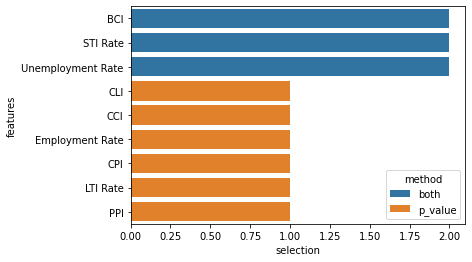

In [7]:
X = dtf_train.drop("max_ratio", axis=1).values
y = dtf_train["max_ratio"].values
feature_names = dtf_train.drop("max_ratio", axis=1).columns

## p-value
selector = feature_selection.SelectKBest(score_func=  
               feature_selection.f_regression, k=9).fit(X,y)
pvalue_selected_features = feature_names[selector.get_support()]

## regularization
selector = feature_selection.SelectFromModel(estimator= 
              linear_model.Ridge(alpha=1.0, fit_intercept=True), 
                                 max_features=9).fit(X,y)
regularization_selected_features = feature_names[selector.get_support()]
 
## plot
dtf_features = pd.DataFrame({"features":feature_names})
dtf_features["p_value"] = dtf_features["features"].apply(lambda x: "p_value" if x in pvalue_selected_features else "")
dtf_features["num1"] = dtf_features["features"].apply(lambda x: 1 if x in pvalue_selected_features else 0)
dtf_features["regularization"] = dtf_features["features"].apply(lambda x: "regularization" if x in regularization_selected_features else "")
dtf_features["num2"] = dtf_features["features"].apply(lambda x: 1 if x in regularization_selected_features else 0)
dtf_features["method"] = dtf_features[["p_value","regularization"]].apply(lambda x: (x[0]+" "+x[1]).strip(), axis=1)
dtf_features["selection"] = dtf_features["num1"] + dtf_features["num2"]
dtf_features["method"] = dtf_features["method"].apply(lambda x: "both" if len(x.split()) == 2 else x)

sns.barplot(y="features", x="selection", hue="method", 
            data=dtf_features.sort_values("selection", ascending=False), dodge=False)

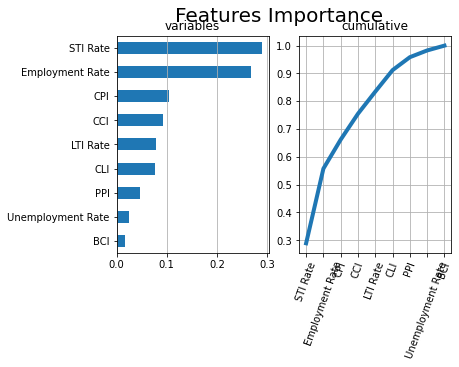

In [8]:
X = dtf_train.drop("max_ratio", axis=1).values
y = dtf_train["max_ratio"].values
feature_names = dtf_train.drop("max_ratio", axis=1).columns.tolist()

## call model
model = ensemble.GradientBoostingRegressor()

## Importance
model.fit(X,y)
importances = model.feature_importances_## Put in a pandas dtf
dtf_importances = pd.DataFrame({"IMPORTANCE":importances, 
            "VARIABLE":feature_names}).sort_values("IMPORTANCE", 
            ascending=False)
dtf_importances['cumsum'] = dtf_importances['IMPORTANCE'].cumsum(axis=0)
dtf_importances = dtf_importances.set_index("VARIABLE")
    
## Plot
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('variables')

dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(
                kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')
dtf_importances[["cumsum"]].plot(kind="line", linewidth=4, 
                                 legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(dtf_importances)), 
          xticklabels=dtf_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')
plt.show()

In [9]:
# Okay, now we know what is worth keeping
X_names = ['STI Rate', 'Employment Rate', 'CCI', 'CPI', 'LTI Rate']
X_train = dtf_train[X_names].values
y_train = dtf_train["max_ratio"].values
X_test = dtf_test[X_names].values
y_test = dtf_test["max_ratio"].values

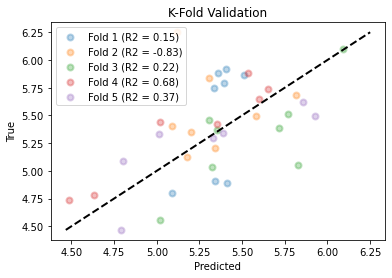

In [10]:
## call model
#model = linear_model.LinearRegression()## K fold validation
model = ensemble.GradientBoostingRegressor()

scores = []
cv = model_selection.KFold(n_splits=5, shuffle=True)
fig = plt.figure()
i = 1
for train, test in cv.split(X_train, y_train):
    prediction = model.fit(X_train[train],
                 y_train[train]).predict(X_train[test])
    true = y_train[test]
    score = metrics.r2_score(true, prediction)
    scores.append(score)
    plt.scatter(prediction, true, lw=2, alpha=0.3, 
                label='Fold %d (R2 = %0.2f)' % (i,score))
    i = i+1
plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], 
         linestyle='--', lw=2, color='black')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('K-Fold Validation')
plt.legend()
plt.show()

In [11]:
## train
model.fit(X_train, y_train)
## test
predicted = model.predict(X_test)

#predicted = scalerY.inverse_transform( 
#                  predicted.reshape(-1,1) ).reshape(-1)

In [12]:
predicted

array([4.72902559, 5.69143785, 5.07255915, 5.24202201, 5.1056323 ,
       5.6319577 , 5.49014943, 5.53937365, 5.3950365 , 4.85390224])

In [13]:
y_test

array([4.57352941, 5.60661765, 4.19117647, 5.14705882, 4.92647059,
       5.97426471, 5.35294118, 5.56985294, 5.05882353, 5.17647059])

In [14]:
## Kpi
print("R2 (explained variance):", round(metrics.r2_score(y_test, predicted), 2))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", round(np.mean(np.abs((y_test-predicted)/predicted)), 2))
print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,.0f}".format(np.sqrt(metrics.mean_squared_error(y_test, predicted))))

## residuals
residuals = y_test - predicted
max_error = max(residuals) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(residuals).index(min(residuals))
max_true, max_pred = y_test[max_idx], predicted[max_idx]
print("Max Error:", "{:,.0f}".format(max_error))

R2 (explained variance): 0.5
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.05
Mean Absolute Error (Σ|y-pred|/n): 0
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 0
Max Error: -1


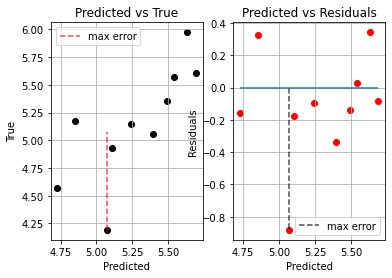

In [15]:
## Plot predicted vs true
fig, ax = plt.subplots(nrows=1, ncols=2)
from statsmodels.graphics.api import abline_plot
ax[0].scatter(predicted, y_test, color="black")
#abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
ax[0].vlines(x=max_pred, ymin=max_true, ymax=max_true-max_error, color='red', linestyle='--', alpha=0.7, label="max error")
ax[0].grid(True)
ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
ax[0].legend()
    
## Plot predicted vs residuals
ax[1].scatter(predicted, residuals, color="red")
ax[1].vlines(x=max_pred, ymin=0, ymax=max_error, color='black', linestyle='--', alpha=0.7, label="max error")
ax[1].grid(True)
ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
ax[1].hlines(y=0, xmin=np.min(predicted), xmax=np.max(predicted))
ax[1].legend()
plt.show()

In [16]:
###### GENERATE PREDICTIONS
current = pd.read_csv('OECD input data - monthly Jan 2018 onward.csv')
current.set_index('TIME', inplace = True)
# current.head()

inPredict = current[len(current)-1:len(current)]
inPredict = inPredict[X_names].values
inPredict

outPredict = model.predict(inPredict)
outPredict


array([4.84250969])